# Fisher forcast computation

In [1]:
import numpy as np
import os
os.environ['JAX_ENABLE_X64']='True'

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

In [4]:
import pyccl as ccl
import jax
import jax_cosmo as jc

In [5]:
print("jax-cosmo version:", jc.__version__)
print("ccl version", ccl.__version__)

jax-cosmo version: 0.1rc9
ccl version 2.5.1


In [6]:
# Create a fiducial cosmology with default parameters
cosmo = jc.Planck15()

In [7]:
#Fictuous redshift distributions
nz1 = jc.redshift.smail_nz(5., 4.,  1.5)
nz2 = jc.redshift.smail_nz(5., 5.,  1.3)
nz3 = jc.redshift.smail_nz(5., 5.,  1.0)
nz4 = jc.redshift.smail_nz(1., 2.,  0.4)

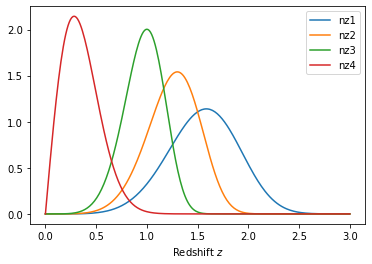

In [8]:
z = np.linspace(0,3,256)

# Redshift distributions are callable, and they return the normalized distribution
plt.plot(z, nz1(z), label='nz1')
plt.plot(z, nz2(z), label='nz2')
plt.plot(z, nz3(z), label='nz3')
plt.plot(z, nz4(z), label='nz4')
plt.legend();
plt.xlabel('Redshift $z$');


In [9]:
nzlens = [nz1, nz4]
nzsrc = [nz2,nz3]

In [10]:
bias  = jc.bias.constant_linear_bias(1.)
tracers = [ jc.probes.WeakLensing(nzlens), 
           jc.probes.NumberCounts(nzsrc, bias) ]

In [11]:
ell = np.logspace(1,3) # Defines a range of \ell

In [12]:
#compute Cells and Covariance matrix
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, tracers, sparse=True);

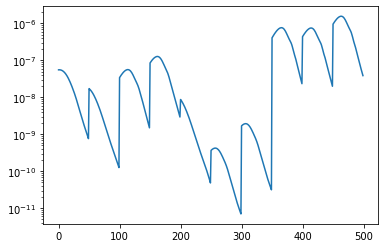

In [13]:
plt.plot(mu)
plt.yscale("log")

### Fisher matrix from LogLikelihood $\mathcal{L}(\theta)=\mathcal{L}(C(\ell;\theta), \Sigma(\ell; \theta))$ hessian
$$
F_{\alpha\beta} = \big\langle \frac{\partial^2\mathcal{L}(\theta)}{\partial \theta_\alpha \partial \theta_\beta}\big\rangle
$$

In [14]:
jc.Planck15

functools.partial(<class 'jax_cosmo.core.Cosmology'>, Omega_c=0.2589, Omega_b=0.0486, Omega_k=0.0, h=0.6774, n_s=0.9667, sigma8=0.8159, w0=-1.0, wa=0.0)

In [15]:
data = mu # We create some fake data from the fiducial cosmology

# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 

# tracers using the redshift selection function & simple bias
bias  = jc.bias.constant_linear_bias(1.)
tracers = [ jc.probes.WeakLensing(nzlens), 
            jc.probes.NumberCounts(nzsrc, bias) ]
@jax.jit
def likelihood(p):
    # Create a new cosmology at these parameters
    cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
    # Compute mean and covariance of angular Cls
    mu, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, tracers, sparse=True)
    # Return likelihood value assuming constant covariance, so we stop the gradient
    # at the level of the precision matrix, and we will not include the logdet term
    # in the likelihood
    P = jc.sparse.inv(jax.lax.stop_gradient(C))
    r = data - mu
    return -0.5 * r.T @ jc.sparse.sparse_dot_vec(P, r)

In [16]:
print(likelihood(params))
%timeit likelihood(params).block_until_ready()

-3.537701993329262e-26
24.8 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
# Compile a function that computes the Hessian of the likelihood
hessian_loglik = jax.jit(jax.hessian(likelihood))

# Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
# This is a bit slow at first....
F = - hessian_loglik(params)

In [18]:
#But once it has been jit-compiled it is ok
%timeit hessian_loglik(params).block_until_ready()

680 ms ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Alternative computation in the case of Gaussian likelihood with $\Sigma(\ell)=\Sigma(\ell; \theta_{fidu.})$ the covariance matrix computed with the fiducial cosmology
$$
F_{\alpha\beta} = \sum_\ell \frac{\partial C(\ell)}{\partial \theta_\alpha}^T \Sigma^{-1}(\ell)\frac{\partial C(\ell)}{\partial \theta_\beta}
$$

In [19]:
# We define a parameter dependent function that computes the mean
@jax.jit
def jc_mean(p):
    cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
    # Compute signal vector
    mu = jc.angular_cl.angular_cl(cosmo, ell, tracers)
    # We want mu in 1d to operate against the covariance matrix
    return mu.flatten() 

In [20]:
jc_mu = jc_mean(params)
%timeit jc_mean(params).block_until_ready()

23.5 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
# We compute it's jacobian with JAX, and we JIT it for efficiency
jac_mean = jax.jit(jax.jacfwd(jc_mean))

In [22]:
# We can now evaluate the jacobian at the fiducial cosmology
dmu = jac_mean(params)

In [23]:
%timeit jac_mean(params).block_until_ready()

50.3 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
# Now we can compose the Fisher matrix:
F_2 = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)

2022-09-14 11:15:25.291132: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[2,2]{1,0} custom-call(f64[2,500]{1,0} %parameter.1, f64[2,500]{1,0} %bitcast.1), custom_call_target="__cublas$gemm", metadata={op_type="dot_general" op_name="jit(dot)/jit(dense_dot_sparse_dot_dense)/dot_general[\n  dimension_numbers=(((1,), (1,)), ((), ()))\n  precision=None\n  preferred_element_type=None\n]" source_file="/tmp/ipykernel_26509/1838037428.py" source_line=2}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"1000\",\"rhs_stride\":\"1000\"}" failed. Falling back to default algorithm. 


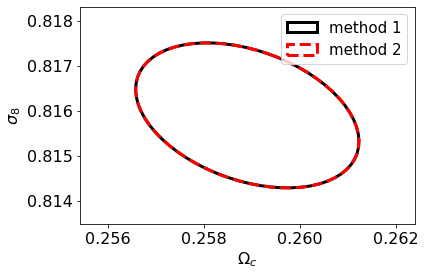

In [43]:
# We can now plot contours obtained so far 
p0_name = '$\Omega_c$'
p1_name = '$\sigma_8$'
plot_contours(F, params, fill=False,color='black',lw=3, label="method 1");
plot_contours(F_2, params, fill=False, color='red', lw=3, linestyle='dashed', label="method 2");
plt.xlabel(p0_name)
plt.ylabel(p1_name);
plt.legend(fontsize=15)

### Fisher matrix obtained with finite difference method.

In [26]:
jc.Planck15()

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

In [27]:
# We define a parameter dependent function that computes the mean
ccl_cte_bias = lambda z: 1.0*np.ones_like(z)
def ccl_mean(p):

    cosmo_ccl = ccl.Cosmology(
        Omega_c=p[0], Omega_b=0.0486,
        h=0.6774, sigma8=p[1],
        n_s=0.9667, w0=-1.0,
        wa=0.0, Neff=0, Omega_g=0., 
        transfer_function='eisenstein_hu', 
        matter_power_spectrum='halofit')
    
    tracers = [ccl.WeakLensingTracer(cosmo_ccl, (z,nz1(z)), use_A_ia=False),
                  ccl.WeakLensingTracer(cosmo_ccl, (z,nz4(z)), use_A_ia=False),
                  ccl.NumberCountsTracer(cosmo_ccl,
                                      has_rsd=False,
                                      dndz=(z, nz2(z)),
                                      bias=(z, ccl_cte_bias(z))),
                  ccl.NumberCountsTracer(cosmo_ccl,
                                      has_rsd=False,
                                      dndz=(z, nz3(z)),
                                      bias=(z, ccl_cte_bias(z)))
              ]
    n_tracers = len(tracers)
    # Compute all cross correlations
    cls = []
    for i in range(n_tracers):
        for j in range(i, n_tracers):
            cls.append(ccl.angular_cl(cosmo_ccl, tracers[i], tracers[j], ell))

    return np.concatenate(cls)

In [28]:
ccl_mu = ccl_mean(params)

In [29]:
%timeit ccl_mean(params)

457 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


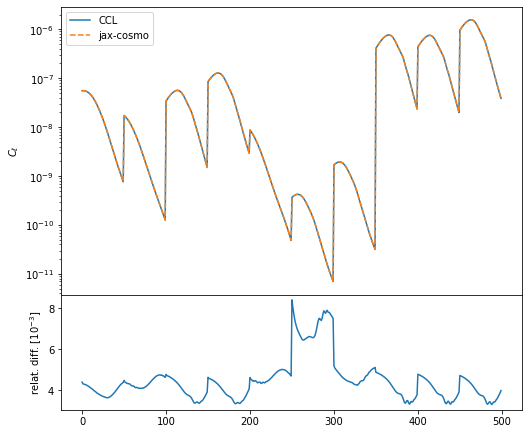

In [30]:
fig1 = plt.figure(1, figsize=(8,8))
frame1=fig1.add_axes((.1,.30,.8,.5))
plt.plot(ccl_mu, label="CCL")
plt.plot(mu,ls="--",label="jax-cosmo")
plt.yscale("log")
plt.ylabel(r"$C_\ell$")
plt.xlabel(r"$\ell$")
plt.legend()

frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(ccl_mu-jc_mu)/jc_mu *1e3
plt.plot(difference)
plt.ylabel(r"relat. diff. $[10^{-3}]$");

In [31]:
import numdifftools as nd

In [32]:
# Defining CCL jacobian
ccl_jac = lambda step: nd.Jacobian(ccl_mean, step=step, order=4)

In [33]:
steps = [0.1, 0.01, 1e-6]

In [34]:
ccl_dmu_1 = ccl_jac(step=steps[0])(params)
ccl_F_1 = jc.sparse.dot(ccl_dmu_1.T, jc.sparse.inv(cov), ccl_dmu_1)

In [35]:
ccl_dmu_2 = ccl_jac(step=steps[1])(params)
ccl_F_2 = jc.sparse.dot(ccl_dmu_2.T, jc.sparse.inv(cov), ccl_dmu_2)

In [36]:
ccl_dmu_3 = ccl_jac(step=steps[2])(params)
ccl_F_3 = jc.sparse.dot(ccl_dmu_3.T, jc.sparse.inv(cov), ccl_dmu_3)

In [37]:
ccl_Fs=[ccl_F_1, ccl_F_2, ccl_F_3]

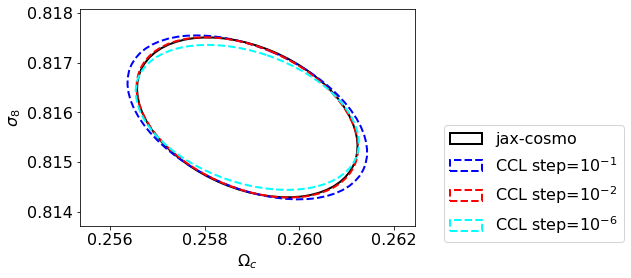

In [44]:
# We can now plot contours obtained with this 
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
f.set_powerlimits((-3,3))
p0_name = '$\Omega_c$'
p1_name = '$\sigma_8$'
#color = iter(mpl.cm.rainbow(np.linspace(0, 1, len(3*ccl_Fs))))
color=np.array(['blue','red','cyan'])
plot_contours(F_2, params, fill=False, color='black', lw=2,label="jax-cosmo");
for idx, F_mtx in enumerate(ccl_Fs):
    #c = next(color)
    plot_contours(F_mtx, params, fill=False,color=color[idx], lw=2, ls="--", label=f"CCL step=${f.format_data(steps[idx])}$");
plt.xlabel(p0_name)
plt.ylabel(p1_name);
plt.legend(loc='best', bbox_to_anchor=(1.15, 0., 0.5, 0.5))

### MOPED compression (simple)

In [39]:
import jax.numpy as jnp

In [40]:
C_inv = jc.sparse.inv(cov)

In [40]:
b0 = jc.sparse.dot(C_inv,dmu[:,0])/jax.numpy.sqrt(F_2[0,0])

In [41]:
b0.T @ jc.sparse.to_dense(cov) @ b0

DeviceArray(1., dtype=float64)

In [42]:
a = dmu[:,1].T @ b0
b1 = (jc.sparse.dot(C_inv,dmu[:,1]) - a * b0)/jax.numpy.sqrt(F_2[1,1]-a*a)

In [43]:
b1.T @ jc.sparse.to_dense(cov) @ b1

DeviceArray(1., dtype=float64)

In [44]:
b0.T @ jc.sparse.to_dense(cov) @ b1

DeviceArray(5.2909066e-16, dtype=float64)

In [45]:
y0 = b0.T @ data
y1 = b1.T @ data

In [46]:
@jax.jit
def compress_likelihood(p):
    # Create a new cosmology at these parameters
    cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
    # Compute mean Cl
    mu = jc.angular_cl.angular_cl(cosmo, ell, tracers).flatten()
    # likelihood using the MOPED vector
    return -0.5 * ((y0 - b0.T @ mu)**2 + (y1 - b1.T @ mu)**2)

In [47]:
compress_likelihood(params)

DeviceArray(-3.63507105e-26, dtype=float64)

In [222]:
%timeit compress_likelihood(params).block_until_ready()

23.8 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
ll = lambda x,y: likelihood(jnp.array([x,y]))

In [51]:
s8_vals = jnp.linspace(0.79,0.84)

In [52]:
ll_s8 = jax.vmap(ll, in_axes=(None,0))(0.2589, s8_vals)

In [53]:
cp_ll = lambda x,y: compress_likelihood(jnp.array([x,y]))

In [54]:
cp_ll_s8 = jax.vmap(cp_ll, in_axes=(None,0))(0.2589,s8_vals)

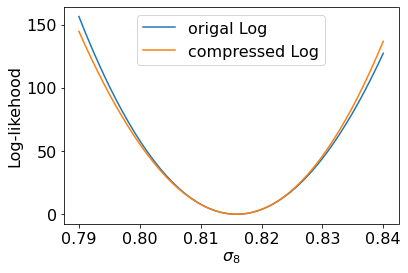

In [57]:
plt.plot(s8_vals,-ll_s8,label="origal Log")
plt.plot(s8_vals,-cp_ll_s8,label="compressed Log")
plt.xlabel("$\sigma_8$")
plt.ylabel("Log-likehood")
plt.legend()

In [68]:
omega_vals = jnp.linspace(0.23,0.28)

In [101]:
tmp = np.zeros((50,50))
for i,Oc in enumerate(omega_vals):
    for j,s8 in enumerate(s8_vals):
        tmp[j,i] = -ll(Oc,s8)

In [87]:
cp_tmp = np.zeros((50,50))
for i,Oc in enumerate(omega_vals):
    for j,s8 in enumerate(s8_vals):
        cp_tmp[j,i] = -cp_ll(Oc,s8)

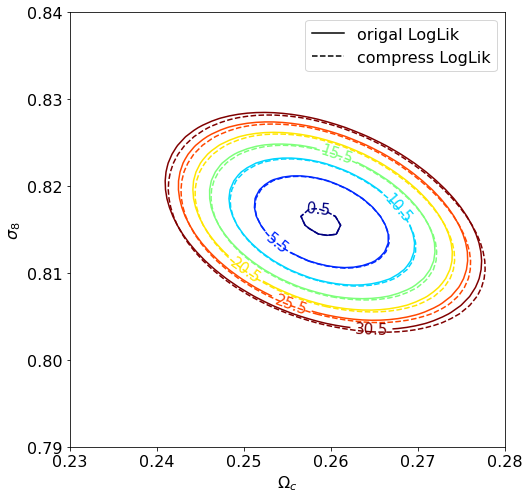

In [128]:
from matplotlib.lines import Line2D
fig1 = plt.figure(1, figsize=(8,8))


CS=plt.contour(omega_vals, s8_vals, tmp, levels=np.arange(0.5,35,5))
handles, labels = plt.gca().get_legend_handles_labels()

plt.gca().set_aspect('equal')
plt.clabel(CS, inline=1, fontsize=15)
plt.contour(omega_vals, s8_vals, cp_tmp, levels=np.arange(0.5,35,5), linestyles="dashed")
plt.xlabel("$\Omega_c$")
plt.ylabel("$\sigma_8$")
#h, _ = CS.legend_elements()
#l = [f'${v}$' for v in np.arange(0.5,35,5)]
#plt.legend(h,l, fontsize=14)
line1 = Line2D([0], [0], label='origal LogLik', color='k')
line2 = Line2D([0], [0], label='compress LogLik', color='k', ls="dashed")
handles.extend([line1,line2])

plt.legend(handles=handles)

In [115]:
l

['$x = 0.5$',
 '$x = 5.5$',
 '$x = 10.5$',
 '$x = 15.5$',
 '$x = 20.5$',
 '$x = 25.5$',
 '$x = 30.5$']

In [116]:
l = [f'${v}$' for v in np.arange(0.5,35,5)]

In [117]:
l

['$0.5$', '$5.5$', '$10.5$', '$15.5$', '$20.5$', '$25.5$', '$30.5$']